## Upsample a hex cube and create mapping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import Delaunay

#### Step 1: Define a unit hex as an example
(Note that local-to-global mapping is trivial in this case)

In [2]:
# Step 1: Define the unit hexahedron vertices
vertices_hex = np.array([
    [0, 0, 0],  # v1
    [1, 0, 0],  # v2
    [1, 1, 0],  # v3
    [0, 1, 0],  # v4
    [0, 0, 1],  # v5
    [1, 0, 1],  # v6
    [1, 1, 1],  # v7
    [0, 1, 1]   # v8
])

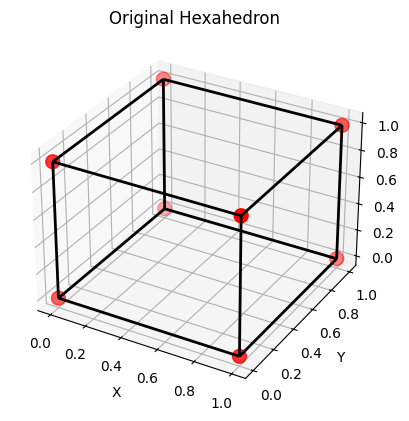

In [3]:
# Plotting function to visualize vertices and edges
def plot_vertices_edges(vertices, edges, title="Vertices and Edges"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], color='r', s=100)
    
    # Create a list of line segments from edge vertices to plot the edges
    edge_lines = [(vertices[start], vertices[end]) for start, end in edges]
    lc = Line3DCollection(edge_lines, colors='k', linewidths=2)
    ax.add_collection(lc)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(title)
    plt.show()

# Define edges for plotting
edges_hex = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face edges
    (4, 5), (5, 6), (6, 7), (7, 4),  # top face edges
    (0, 4), (1, 5), (2, 6), (3, 7),  # vertical edges
]

# Plot original vertices and edges
plot_vertices_edges(vertices_hex, edges_hex, "Original Hexahedron")

#### Step 2: Define quadratic spline bases for 3D

In [4]:
# Quadratic B-spline basis functions in 1D
def B0(u):
    return (1 - u)**2 / 2 if 0 <= u <= 1 else 0

def B1(u):
    return (-2*u**2 + 2*u + 1) / 2 if 0 <= u <= 1 else 0

def B2(u):
    return u**2 / 2 if 0 <= u <= 1 else 0

# 3D Quadratic B-spline basis functions using tensor product
def B_ijk(i, j, k, u, v, w):
    # Basis functions along each axis
    basis_u = [B0(u), B1(u), B2(u)]
    basis_v = [B0(v), B1(v), B2(v)]
    basis_w = [B0(w), B1(w), B2(w)]
    
    # Tensor product of basis functions
    return basis_u[i] * basis_v[j] * basis_w[k]

# Evaluate basis functions at a specific point in the parametric space (u, v, w)
def evaluate_spline_basis(u, v, w):
    values = np.zeros((3, 3, 3))  # Initialize a 3x3x3 grid for basis function values
    for i in range(3):
        for j in range(3):
            for k in range(3):
                values[i, j, k] = B_ijk(i, j, k, u, v, w)
    return values

#### Step 3: Upsampling and Triangulation Data Preparation

In [7]:
# Step 3: Upsample and Triangulate Hexahedral Faces
def upsample_and_triangulate_hex(vertices_hex):
    vertices_hex = np.array(vertices_hex, dtype=np.float64)

    faces_indices = [
        (0, 1, 2, 3),
        (4, 5, 6, 7),
        (0, 1, 5, 4),
        (1, 2, 6, 5),
        (2, 3, 7, 6),
        (3, 0, 4, 7),
    ]

    upsampled_points = []
    triangulated_faces = []
    point_index_offset = 0

    for face in faces_indices:
        face_vertices = vertices_hex[np.array(face)]
        mid_points = [(face_vertices[i] + face_vertices[(i+1) % 4]) / 2 for i in range(4)]
        all_points = np.vstack([face_vertices, mid_points])
        center_point = np.mean(face_vertices, axis=0)
        all_points = np.vstack([all_points, center_point])

        upsampled_points.extend(all_points)

        # Projecting onto the plane with the greatest spread of points
        projections = [all_points[:, [1, 2]], all_points[:, [0, 2]], all_points[:, [0, 1]]]
        areas = [np.ptp(proj[:, 0]) * np.ptp(proj[:, 1]) for proj in projections]
        points2d = projections[np.argmax(areas)]

        # Safe check if the projected area is zero, which indicates colinear points in 2D
        if np.ptp(points2d[:, 0]) == 0 or np.ptp(points2d[:, 1]) == 0:
            continue

        try:
            delaunay_tri = Delaunay(points2d)
            for simplex in delaunay_tri.simplices:
                triangulated_faces.append([point_index_offset + i for i in simplex])
        except Exception as e:
            print("Failed to triangulate face:", e)
            continue

        point_index_offset += len(all_points)

    return np.array(upsampled_points), np.array(triangulated_faces)

# Assuming vertices_hex is defined as your hexahedral vertices
upsampled_points, triangulated_faces = upsample_and_triangulate_hex(vertices_hex)

# Now, you can use upsampled_points and triangulated_faces for further processing or visualization

#### Step 4: Local-global mapping

In [9]:
# Define the reference and real hexahedrons (identical in this case)
reference_hex = vertices_hex  # This is the same as vertices_hex defined earlier
real_hex = reference_hex.copy()  # Make a copy for clarity, though they're identical in this case


TODO: Add mapping for general hex cubes

### Step 5: Construct W: Mapping between S and M

In [10]:
# Evaluate the basis functions at each of the upsampled points
spline_values_at_points = [evaluate_spline_basis(point[0], point[1], point[2]) for point in upsampled_points]

# Initialize matrix W with zeros; this will be a 3D matrix where the third dimension corresponds to x, y, and z coordinates
W = np.zeros((len(upsampled_points), len(reference_hex), 3))

# Fill in matrix W with the evaluated spline values
for i, spline_values in enumerate(spline_values_at_points):
    for j, ref_point in enumerate(reference_hex):
        # Since there's no deformation, the weight is simply the spline value at the point
        W[i, j, :] = spline_values[j // 3, (j // 3) % 3, j % 3]

In [18]:
print(len(spline_values_at_points))
print(spline_values_at_points[0].shape)

54
(3, 3, 3)


In [14]:
print(W[:, :, 0])

[[0.125     0.125     0.        0.125     0.125     0.        0.
  0.       ]
 [0.        0.        0.        0.125     0.125     0.        0.
  0.       ]
 [0.        0.        0.        0.125     0.125     0.        0.125
  0.125    ]
 [0.        0.        0.        0.125     0.125     0.        0.
  0.       ]
 [0.03125   0.03125   0.        0.1875    0.1875    0.        0.
  0.       ]
 [0.        0.        0.        0.1875    0.1875    0.        0.03125
  0.03125  ]
 [0.        0.        0.        0.1875    0.1875    0.        0.03125
  0.03125  ]
 [0.03125   0.03125   0.        0.1875    0.1875    0.        0.
  0.       ]
 [0.0078125 0.0078125 0.        0.28125   0.28125   0.        0.0078125
  0.0078125]
 [0.        0.125     0.125     0.        0.125     0.125     0.
  0.       ]
 [0.        0.        0.        0.        0.125     0.125     0.
  0.       ]
 [0.        0.        0.        0.        0.125     0.125     0.
  0.125    ]
 [0.        0.        0.        0.        0.

## Implementation

In [2]:
import pyvista as pv
import numpy as np
import scipy.sparse as sp
import h5py

#### Use a unit hex as an example

/Users/liujunyu/miniforge3/envs/IGA-IPC/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/liujunyu/miniforge3/envs/IGA-IPC/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


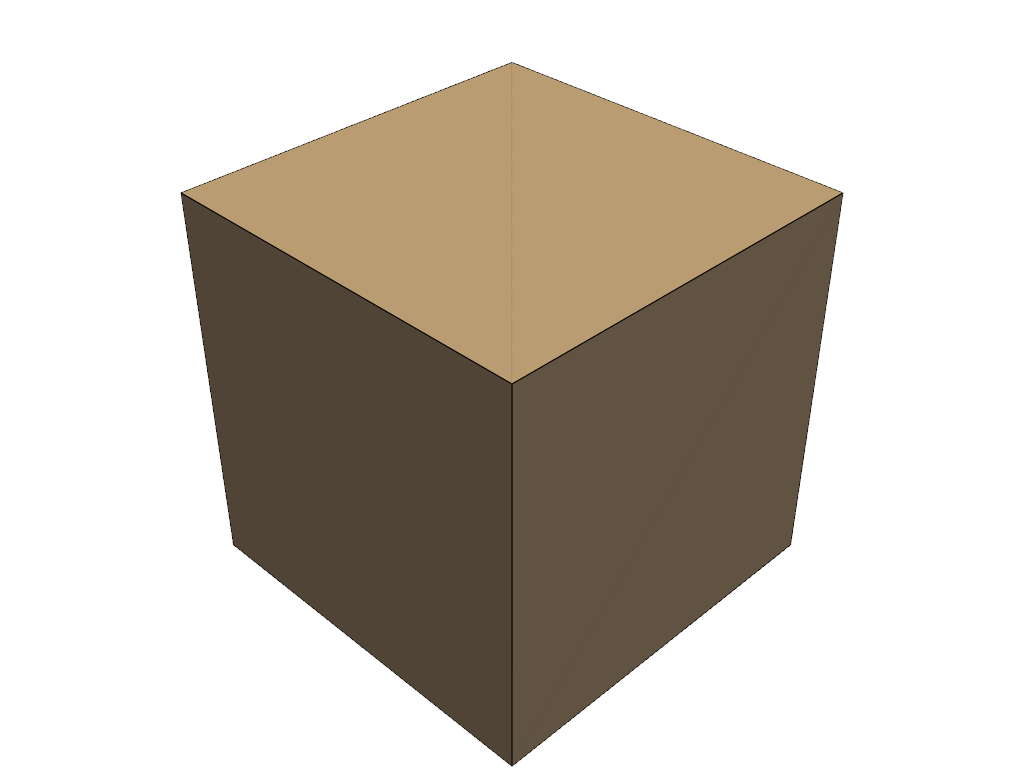

: 

In [12]:
# Define the vertices of the unit cube
vertices = np.array([[0, 0, 0],
                     [1, 0, 0],
                     [1, 1, 0],
                     [0, 1, 0],
                     [0, 0, 1],
                     [1, 0, 1],
                     [1, 1, 1],
                     [0, 1, 1]])

# Hexahedral connectivity in VTK cell format
# PyVista requires a cell array where the first number is the number of points in the cell
# followed by the indices of the points that form the cell
cells = np.hstack(([[8], [0, 1, 2, 3, 4, 5, 6, 7]]))

# Create the unstructured grid
hex_mesh = pv.UnstructuredGrid(cells, np.array([pv.CellType.HEXAHEDRON]), vertices)
surface_mesh = hex_mesh.extract_surface()
surface_mesh.save('hex.ply')

# Visualize the mesh
plotter = pv.Plotter()
plotter.add_mesh(hex_mesh, show_edges=True, color="tan")
plotter.show()

#### Define spline basis functions

In [4]:
# Linear basis functions for a cube
def linear_basis_functions(hex_point):
    """
    Linear basis functions for a hexahedron (cube) at a given point.

    Parameters:
    hex_point (np.array): The (x, y, z) coordinates of the point within the hexahedron.
    
    Returns:
    np.array: An array of the eight basis function values at the given point.
    """
    x, y, z = hex_point
    return np.array([
        (1-x)*(1-y)*(1-z),  # Vertex 0
        x*(1-y)*(1-z),      # Vertex 1
        x*y*(1-z),          # Vertex 2
        (1-x)*y*(1-z),      # Vertex 3
        (1-x)*(1-y)*z,      # Vertex 4
        x*(1-y)*z,          # Vertex 5
        x*y*z,              # Vertex 6
        (1-x)*y*z           # Vertex 7
    ])

# Quadratic basis functions for a cube
def quadratic_basis_functions(hex_point):
    """
    Quadratic basis functions for a hexahedron (cube) at a given point.
    
    Parameters:
    hex_point (np.array): The (x, y, z) coordinates of the point within the hexahedron.
    
    Returns:
    np.array: An array of the 27 basis function values at the given point.
    """
    x, y, z = hex_point
    # The eight corner points
    phi_0 = (1-x)*(1-y)*(1-z)
    phi_1 = x*(1-y)*(1-z)
    phi_2 = x*y*(1-z)
    phi_3 = (1-x)*y*(1-z)
    phi_4 = (1-x)*(1-y)*z
    phi_5 = x*(1-y)*z
    phi_6 = x*y*z
    phi_7 = (1-x)*y*z

    # The twelve edge points
    phi_8 = (1-x)*(1-y)*z
    phi_9 = x*(1-y)*z
    phi_10 = x*y*z
    phi_11 = (1-x)*y*z
    
    # The six face points (center of each face)
    phi_12 = 0.5*(1-x)*(1-y)
    phi_13 = 0.5*x*(1-y)
    phi_14 = 0.5*x*y
    phi_15 = 0.5*(1-x)*y
    phi_16 = 0.5*(1-x)*z
    phi_17 = 0.5*x*z
    phi_18 = 0.5*y*z
    phi_19 = 0.5*(1-y)*z

    # One center point
    phi_20 = 0.5*(1-x)
    phi_21 = 0.5*x
    phi_22 = 0.5*(1-y)
    phi_23 = 0.5*y
    phi_24 = 0.5*(1-z)
    phi_25 = 0.5*z
    phi_26 = 0.125  # Center of the cube

    return np.array([
        phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6, phi_7,
        phi_8, phi_9, phi_10, phi_11, phi_12, phi_13, phi_14, phi_15,
        phi_16, phi_17, phi_18, phi_19, phi_20, phi_21, phi_22, phi_23,
        phi_24, phi_25, phi_26
    ])

# Test the basis functions at the center of the hexahedron
test_point = np.array([0.5, 0.5, 0.5])

linear_basis = linear_basis_functions(test_point)
quadratic_basis = quadratic_basis_functions(test_point)

linear_basis, quadratic_basis

(array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]),
 array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.125]))

#### Create reference hex and calculate local-glocal mapping

In [6]:
# Define the reference hex as a unit cube in the parametric space
# Here we define it in the range [0, 1] for each dimension
reference_points = np.array([
    [0, 0, 0],  # Node 0
    [1, 0, 0],  # Node 1
    [1, 1, 0],  # Node 2
    [0, 1, 0],  # Node 3
    [0, 0, 1],  # Node 4
    [1, 0, 1],  # Node 5
    [1, 1, 1],  # Node 6
    [0, 1, 1]   # Node 7
])

# The mapping from the reference hex to the actual hex is an identity map in this case
# However, to represent it formally:
def map_from_reference_to_actual(reference_point):
    """
    Map a point from the reference hex to the actual hex.
    
    Since the actual hex is a unit cube aligned with the axes, this is just an identity function.
    
    Parameters:
    reference_point (np.array): A point in the reference hexahedron.
    
    Returns:
    np.array: The same point in the actual hexahedron.
    """
    return reference_point

# Test the mapping with the center of the reference hex
center_of_reference_hex = np.array([0.5, 0.5, 0.5])
mapped_center = map_from_reference_to_actual(center_of_reference_hex)

# Output the mapped center for verification
mapped_center


array([0.5, 0.5, 0.5])

#### Usample to create triangle collision mesh

/Users/liujunyu/miniforge3/envs/IGA-IPC/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/liujunyu/miniforge3/envs/IGA-IPC/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


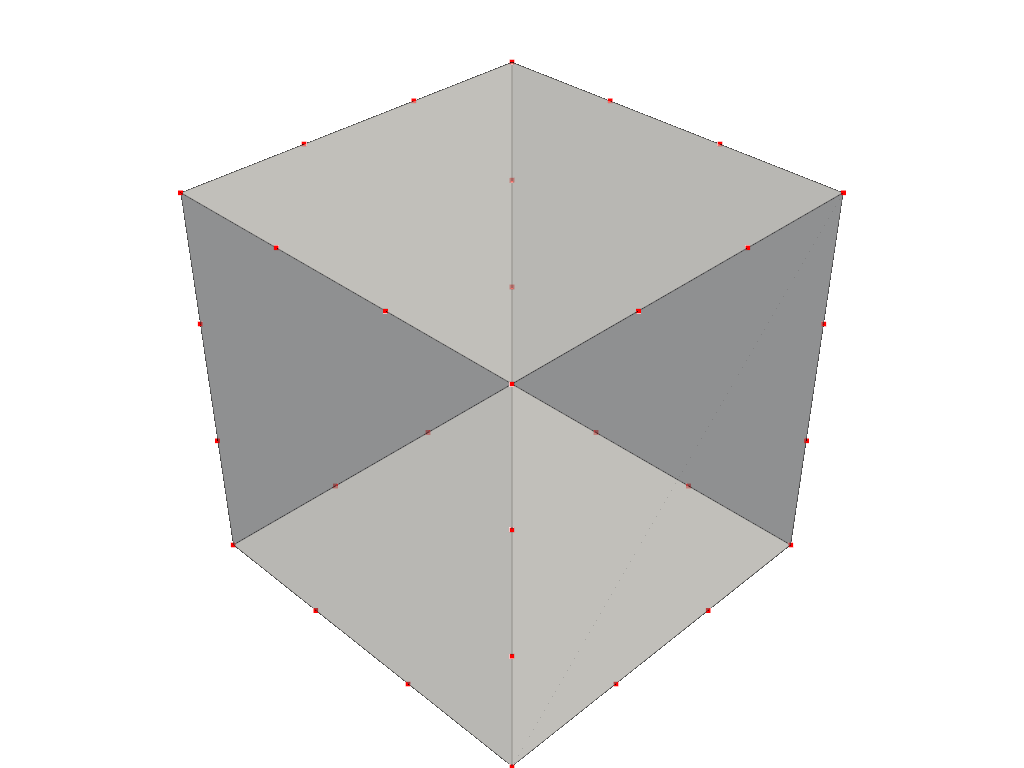

In [8]:
def interpolate_edge_points(point1, point2, num_points):
    """
    Generate additional points between two vertices.

    Parameters:
    point1 (np.array): The starting vertex.
    point2 (np.array): The ending vertex.
    num_points (int): Number of points to interpolate (excluding the original vertices).

    Returns:
    np.array: Interpolated points between the two vertices.
    """
    return np.linspace(point1, point2, num_points + 2)[1:-1]  # Exclude the original vertices

# Assuming hex_mesh is your original hex mesh
# First, extract the surface to work with surface vertices
surface_mesh = hex_mesh.extract_surface()
vertices = surface_mesh.points
cell_array = surface_mesh.faces

# Assuming the surface is purely hexahedral which might not be directly applicable, let's manually handle this
upsampled_points = set(tuple(vertex) for vertex in vertices)

# Number of points to interpolate between each vertex pair
num_interpolated_points = 2  # Increase or decrease based on desired density

# Iterate over cells in the mesh
offset = 0
while offset < len(cell_array):
    cell_size = cell_array[offset]
    cell_indices = cell_array[offset + 1: offset + 1 + cell_size]
    # Iterate through pairs of vertices in the cell
    for i in range(cell_size):
        point1, point2 = vertices[cell_indices[i]], vertices[cell_indices[(i + 1) % cell_size]]
        new_points = interpolate_edge_points(point1, point2, num_interpolated_points)
        upsampled_points.update(map(tuple, new_points))
    offset += 1 + cell_size

# Convert the set back to a numpy array
upsampled_points = np.array(list(upsampled_points))

# Optional: visualize the points to confirm their placement
point_cloud = pv.PolyData(upsampled_points)
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, color='red', point_size=5)
plotter.add_mesh(hex_mesh, color='white', show_edges=True, opacity=0.5)
plotter.show()

/Users/liujunyu/miniforge3/envs/IGA-IPC/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/liujunyu/miniforge3/envs/IGA-IPC/lib/python3.9/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


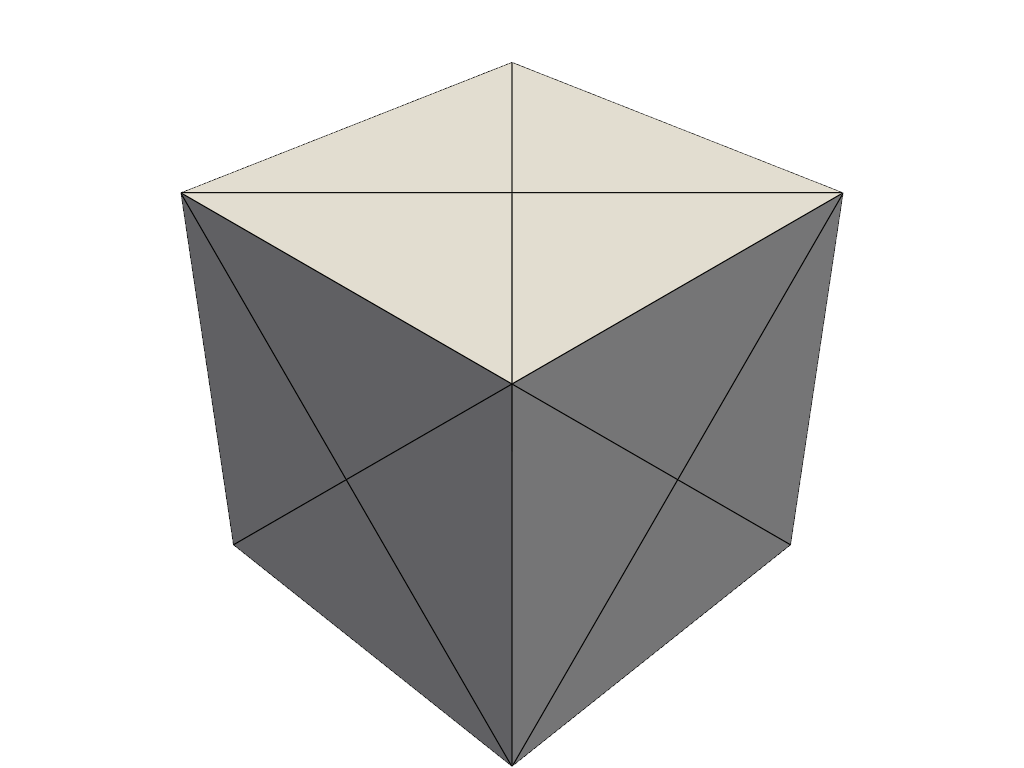

In [6]:
# def interpolate_points_on_edges(mesh, num_divisions=2):
#     """
#     Interpolates points on each edge of the mesh to refine the mesh detail.

#     Parameters:
#     mesh (pyvista.PolyData): The original mesh to refine.
#     num_divisions (int): Number of divisions per edge.

#     Returns:
#     pyvista.PolyData: The new mesh with additional interpolated points.
#     """
#     # Extract edges and points
#     edges = mesh.extract_all_edges()
#     edge_points = edges.points
#     edge_cells = edges.lines

#     # Process each edge to extract unique edges
#     unique_edges = set()
#     for i in range(0, len(edge_cells) - 1, 3):
#         pt1_idx, pt2_idx = edge_cells[i+1], edge_cells[i+2]
#         pt1, pt2 = edge_points[pt1_idx], edge_points[pt2_idx]
#         edge = tuple(sorted((tuple(pt1), tuple(pt2)), key=lambda x: (x[0], x[1], x[2])))  # Sorting by coordinates
#         unique_edges.add(edge)

#     # Create new points by interpolating along edges
#     new_points = []
#     for pt1, pt2 in unique_edges:
#         new_points.extend(np.linspace(pt1, pt2, num=num_divisions + 2)[1:-1])  # Exclude original endpoints

#     # Combine old and new points
#     all_points = np.vstack([mesh.points] + new_points)
#     point_cloud = pv.PolyData(all_points)

#     # Triangulate the point cloud to form a surface
#     surface = point_cloud.delaunay_2d()

#     return surface

def subdivide_quad_faces(mesh):
    """
    Subdivides each quadrilateral face of the mesh by adding a central vertex connected to each vertex of the face.

    Parameters:
    mesh (pyvista.PolyData): The original mesh to refine.

    Returns:
    pyvista.PolyData: The new mesh with faces subdivided.
    """
    points = mesh.points
    new_points = points.tolist()  # Convert to list for easier append operations
    new_polys = []

    # Process each face assuming they are quads
    for i in range(0, len(mesh.faces), 5):  # skip every 5 items (4 vertices + 1 count of vertices)
        face = mesh.faces[i+1:i+5]
        verts = points[face]
        centroid = verts.mean(axis=0)
        centroid_index = len(new_points)
        new_points.append(centroid)  # Add new centroid point

        # Create new faces connecting the centroid to each edge of the face
        for j in range(4):
            new_polys.extend([3, face[j], face[(j+1) % 4], centroid_index])

    # Create new mesh with updated points and faces
    new_mesh = pv.PolyData(np.array(new_points), np.hstack(new_polys))

    return new_mesh

# Assuming hex_mesh is your original hex mesh
# Extract the surface and interpolate points
surface_mesh = hex_mesh.extract_surface()
# upsampled_surface = interpolate_points_on_edges(surface_mesh, num_divisions=3)
upsampled_surface = subdivide_quad_faces(surface_mesh)

# Save the upsampled surface mesh to an OBJ file
upsampled_surface.save('upsampled_surface.ply')

# Visualize the upsampled surface mesh
plotter = pv.Plotter()
plotter.add_mesh(upsampled_surface, color='white', show_edges=True)
plotter.show()

#### Construct W and save the mapping to .hdf5

In [7]:
# Assume `quadratic_basis_functions` is defined as per your spline basis
# Example: Quadratic basis functions defined in a previous conversation snippet

def evaluate_basis_functions_at_points(basis_functions, points):
    """
    Evaluate all basis functions at each point in a given set of points.

    Parameters:
    basis_functions (callable): The basis function that accepts a point and returns basis values.
    points (np.array): An array of points where the basis functions should be evaluated.

    Returns:
    np.array: A 2D array where each row corresponds to a point and each column to a basis function value.
    """
    return np.array([basis_functions(point) for point in points])

# # Assume `upsampled_points` are the points on surface S and `hex_mesh.points` are points in M
# basis_values_at_points = evaluate_basis_functions_at_points(quadratic_basis_functions, upsampled_points)

# # Construct the W matrix
# num_surface_points = upsampled_points.shape[0]
# num_basis_functions = len(quadratic_basis_functions(hex_mesh.points[0]))  # Assume this evaluates the number of basis functions

# # Initialize W as a sparse matrix
# W = sp.lil_matrix((num_surface_points, num_basis_functions))

# for i in range(num_surface_points):
#     for j in range(num_basis_functions):
#         W[i, j] = basis_values_at_points[i][j]

# # Optionally, convert to a more efficient format for operations
# W_csr = W.tocsr()

# Extract necessary topology data for 'ordered_edges' and 'ordered_faces'
edges = upsampled_surface.extract_all_edges()

# Extracting edge points can lead to ambiguity due to sorting of actual coordinate arrays.
# Instead, sort indices or directly work with data structured to identify edges uniquely.
# Initialize a set to store unique edges
unique_edges = set()

# Loop through edge array which contains pairs of indices pointing to the vertices forming the edge
for i in range(0, len(edges.lines) - 1, 3):  # Assuming lines array structure: [2, point1, point2, 2, point3, point4, ...]
    pt1, pt2 = edges.lines[i+1], edges.lines[i+2]
    ordered_edge = tuple(sorted((pt1, pt2)))  # Sort indices, not points
    unique_edges.add(ordered_edge)

# Now convert the unique edges into an appropriate numpy array format for further processing
unique_edges_array = np.array(list(unique_edges), dtype=np.int64)

faces = upsampled_surface.faces.reshape(-1, 4)[:, 1:]  # Assuming faces are triangular (3 vertices per face plus face size integer)

# Now evaluate basis functions at the points of the collision mesh
basis_values_at_points = evaluate_basis_functions_at_points(quadratic_basis_functions, upsampled_surface.points)

# Construction of the W matrix
num_surface_points = upsampled_surface.n_points
num_basis_functions = basis_values_at_points.shape[1]  # Assuming the quadratic_basis_functions return consistent number

# Initialize W as a sparse matrix
W = sp.lil_matrix((num_surface_points, num_basis_functions))

for i in range(num_surface_points):
    for j in range(num_basis_functions):
        W[i, j] = basis_values_at_points[i][j]

# Convert W to CSR format
W_csr = W.tocsr()

# print(W_csr)
print(W_csr.shape)

(14, 27)


In [8]:
def get_row_indices(csrmatrix):
    """ Generate a full list of row indices from a CSR matrix's indptr array. """
    row_indices = np.repeat(np.arange(csrmatrix.shape[0]), np.diff(csrmatrix.indptr))
    return row_indices

# Generate the row indices for CSR matrix
row_indices = get_row_indices(W_csr)

# Now we can save the data properly
# with h5py.File('W_matrix.hdf5', 'w') as f:
#     f.create_dataset('rows', data=row_indices)
#     f.create_dataset('cols', data=W_csr.indices)
#     f.create_dataset('values', data=W_csr.data)

# Convert this set to a sorted numpy array
unique_edges = np.array(list(unique_edges), dtype=np.int64)
unique_edges = unique_edges[np.lexsort((unique_edges[:,1], unique_edges[:,0]))]  # Sorting by columns for consistency

with h5py.File('W_matrix.hdf5', 'w') as f:
    # Save edges and faces
    f.create_dataset('ordered_edges', data=unique_edges, dtype=np.int64)
    f.create_dataset('ordered_faces', data=faces, dtype=np.int64)
    
    # Save the weight triplets
    weight_group = f.create_group('weight_triplets')
    weight_group.create_dataset('cols', data=W_csr.indices, dtype=np.int32)
    weight_group.create_dataset('rows', data=np.repeat(np.arange(W_csr.shape[0]), np.diff(W_csr.indptr)), dtype=np.int32)
    weight_group.create_dataset('values', data=W_csr.data, dtype=np.float64)

In [9]:
def print_hdf5_structure(filename):
    """
    Prints the structure of an HDF5 file.
    
    Parameters:
        filename (str): The path to the HDF5 file.
    """
    def recursive_print(name, node):
        indent = len(name.split('/')) * '  '
        if isinstance(node, h5py.Dataset):
            print(f"{indent}- Dataset '{name}' with shape {node.shape} and type {node.dtype}")
        elif isinstance(node, h5py.Group):
            print(f"{indent}- Group '{name}'")
        else:
            print(f"{indent}- Unknown item '{name}'")

    with h5py.File(filename, 'r') as file:
        file.visititems(recursive_print)

print_hdf5_structure('W_matrix.hdf5')

  - Dataset 'ordered_edges' with shape (36, 2) and type int64
  - Dataset 'ordered_faces' with shape (24, 3) and type int64
  - Group 'weight_triplets'
    - Dataset 'weight_triplets/cols' with shape (164,) and type int32
    - Dataset 'weight_triplets/rows' with shape (164,) and type int32
    - Dataset 'weight_triplets/values' with shape (164,) and type float64
